In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor,OLSInfluence
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS, add_constant

In [2]:
df = pd.read_csv("Encoded_House.csv")

target_column = 'log_price'
x = df.drop(['log_price','price'],axis=1)
y = df[target_column]

scaler = StandardScaler()
x_scaled = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)

# Fit linear model
x_const = sm.add_constant(x_scaled)
model = sm.OLS(y, x_const).fit()
residuals = model.resid

fitted_vals = model.fittedvalues
residuals = model.resid

### 1. Linearity Check

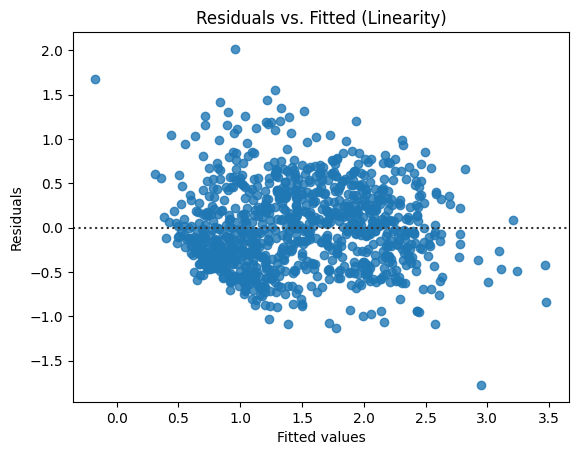

In [3]:
sns.residplot(x=fitted_vals, y=residuals, line_kws={'color': 'red'})
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Fitted (Linearity)')
plt.show()


### 2.Multicollinearity

In [4]:
# VIF calculation
vif = pd.DataFrame()
vif["Feature"] = x.columns
vif["VIF"] = [variance_inflation_factor(x_scaled.values, i) for i in range(x_scaled.shape[1])]
print(vif)

                             Feature        VIF
0                               area   1.042347
1                            bedRoom   7.889810
2                           bathroom   8.995614
3                            balcony   1.940786
4                           floorNum   1.201401
5                             others   1.271263
6                         pooja room   1.889087
7                       servant room   2.079262
8                         store room   1.561607
9                         study room   1.819676
10                       Environment  27.939590
11                         Lifestyle  44.469253
12                      Connectivity  31.950594
13                            Safety  35.887706
14                          Wardrobe   3.739408
15                               Fan   4.113112
16                       Exhaust Fan   2.759238
17                            Geyser   4.066087
18                             Light   2.191240
19                   Modular Kitchen   2

### 3.Normality
#### Histogram + QQ plot + Shapiro-Wilk Test

Shapiro-Wilk Test: Stat=0.987, p-value=0.000


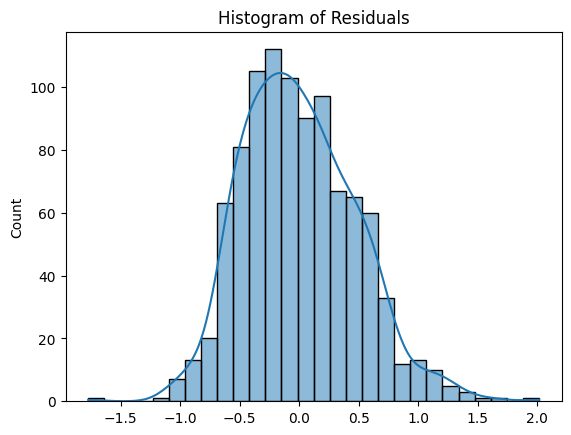

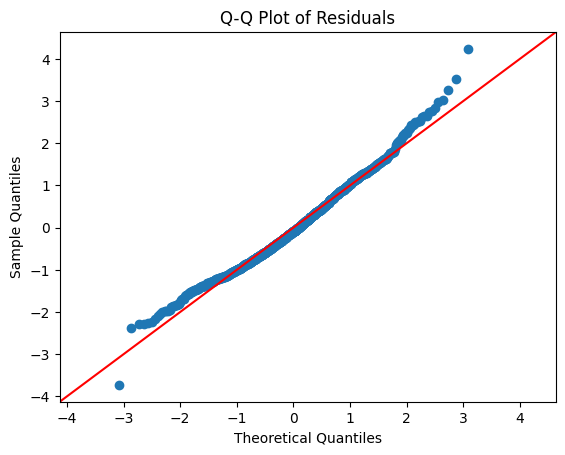

In [5]:
shapiro_stat, shapiro_p = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: Stat={shapiro_stat:.3f}, p-value={shapiro_p:.3f}")

sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Residuals")
plt.show()


### 4. Outliers

f:\Regression_project\venv_reg\Lib\site-packages\statsmodels\stats\outliers_influence.py:847: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)


Standardized Residual Outliers: [207, 228, 236, 506, 623]
Z-Score Outliers: [207, 236, 242, 506, 623]


Text(0, 0.5, 'Z-Score')

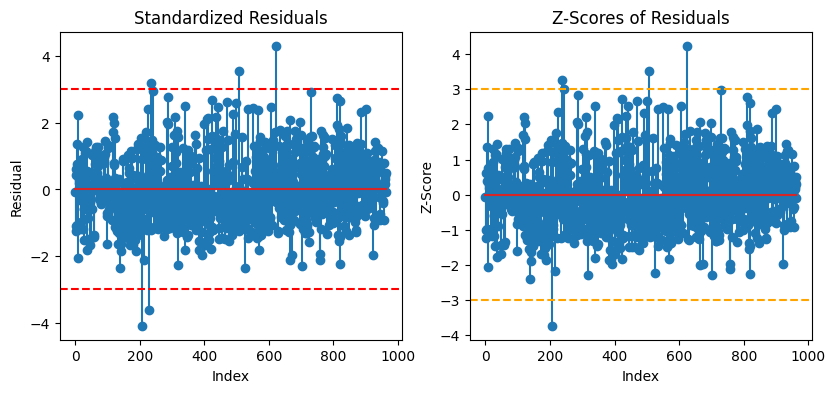

In [6]:
influence = model.get_influence()
standardized_residuals = influence.resid_studentized_internal
cooks_d, _ = influence.cooks_distance

z_scores = zscore(model.resid)

std_resid_outliers = np.where(np.abs(standardized_residuals) > 3)[0]
z_score_outliers = np.where(np.abs(z_scores) > 3)[0]

combined_outliers = np.unique(np.concatenate((std_resid_outliers, z_score_outliers)))
print(f"Standardized Residual Outliers: {std_resid_outliers.tolist()}")
print(f"Z-Score Outliers: {z_score_outliers.tolist()}")

# === Plotting ===
plt.figure(figsize=(15, 4))

# --- Standardized Residuals Plot ---
plt.subplot(1, 3, 1)
plt.stem(standardized_residuals)
plt.axhline(y=3, color='red', linestyle='--')
plt.axhline(y=-3, color='red', linestyle='--')
plt.title("Standardized Residuals")
plt.xlabel("Index")
plt.ylabel("Residual")

# --- Z-Scores Plot ---
plt.subplot(1, 3, 2)
plt.stem(z_scores)
plt.axhline(y=3, color='orange', linestyle='--')
plt.axhline(y=-3, color='orange', linestyle='--')
plt.title("Z-Scores of Residuals")
plt.xlabel("Index")
plt.ylabel("Z-Score")



### 5.Homoscedasticity (Equal variance of residuals)

Breusch-Pagan p-value: 0.0005


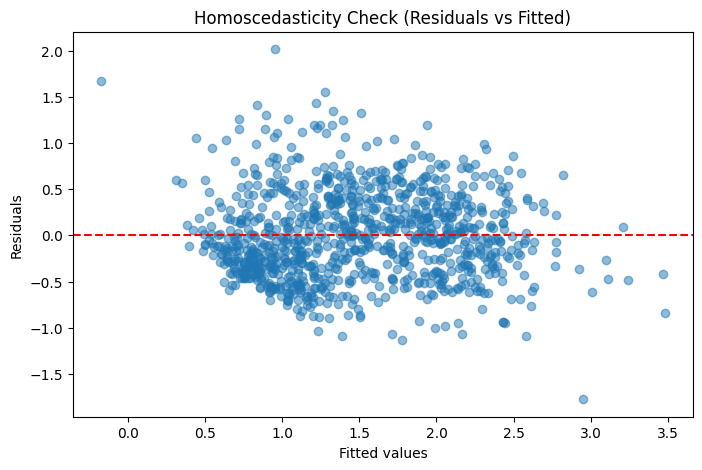

In [9]:
_, pval, _, _ = het_breuschpagan(residuals, model.model.exog)
print(f"Breusch-Pagan p-value: {pval:.4f}")

plt.figure(figsize=(8, 5))
plt.scatter(fitted_vals, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.title("Homoscedasticity Check (Residuals vs Fitted)")
plt.show()
